# Predictng Students Performance in Exams

## Table of Contents
1. [Objective](#Objective)
2. [Data Loading](#Data-Loading)
3. [Exploratory Data Analysis](#Exploratory-Data-Analysis-(EDA))
4. [Preprocessing](#Preprocessing)
5. [Modeling & Evaluation](#Modeling-&-Evaluation)
    - [Linear Regression](#Linear-Regression)
    - [Polynomial Regression](#Polynomial-Regression)
    - [Random Forest](#Random-Forest)
    - [XGBoost](#XGBoost)
    - [Hypertuning](#Hypertuning)
7. [Conclusion](#Conclusion)

## Objective

- This project aims to understand how student performance (Average Scores) is influenced by various features such as `Gender`, `Ethnicity`, `Parental Level of Education`, `Lunch`, and `Test Preparation Course`.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV

## Data Loading

In [2]:
df = pd.read_csv(r"C:\Users\Dell\Desktop\Student Academic Performance\Data\StudentsPerformance.csv")
df.head(5)

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [3]:
print(f"The Dataset Consist of {df.shape} Rows & Columns")

The Dataset Consist of (1000, 8) Rows & Columns


In [4]:
print(f"The Dataset information:")
df.info()

The Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


- The Dataset consist of student demographic details and their academic performance in three subjects.  
- There is no missing values in the dataset.
- Categorical Features : `gender` `race/ethnicity` `parental level of education` `lunch` `test preparation course`.
- Numerical Features: `math score` `reading score` `writing score`.

In [5]:
print(f"The Basic Summary: \n{df.describe()}")

The Basic Summary: 
       math score  reading score  writing score
count  1000.00000    1000.000000    1000.000000
mean     66.08900      69.169000      68.054000
std      15.16308      14.600192      15.195657
min       0.00000      17.000000      10.000000
25%      57.00000      59.000000      57.750000
50%      66.00000      70.000000      69.000000
75%      77.00000      79.000000      79.000000
max     100.00000     100.000000     100.000000


- Math has a minimum of 0 --> at least one student completely failed math.
- Maximum is 100 for all three subjects --> some students scored full marks.
- Median (50%) ≈ Mean for all scores --> the distributions are likely close to normal (bell-shaped).
- Standard deviations are all around 15 points, showing a fairly wide range of performance. There are both high achievers and low performers.
- Since math scores have the lowest mean and lowest minimum, math may be the most challenging subject for students.

## Data Cleaning 

In [6]:
# Checking for missing values
df.isna().sum()

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64

- No Missing Values Found

In [7]:
# Checking for duplication
duplicate = df.duplicated().sum()
print(f"The Number of Duplication: {duplicate}")    

The Number of Duplication: 0


- No Duplication Found

In [8]:
for col in ['gender' , 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']:
    print(f"The Unique Values in {df[col].value_counts()}\n")

The Unique Values in gender
female    518
male      482
Name: count, dtype: int64

The Unique Values in race/ethnicity
group C    319
group D    262
group B    190
group E    140
group A     89
Name: count, dtype: int64

The Unique Values in parental level of education
some college          226
associate's degree    222
high school           196
some high school      179
bachelor's degree     118
master's degree        59
Name: count, dtype: int64

The Unique Values in lunch
standard        645
free/reduced    355
Name: count, dtype: int64

The Unique Values in test preparation course
none         642
completed    358
Name: count, dtype: int64



## Exploratory Data Analysis (EDA)

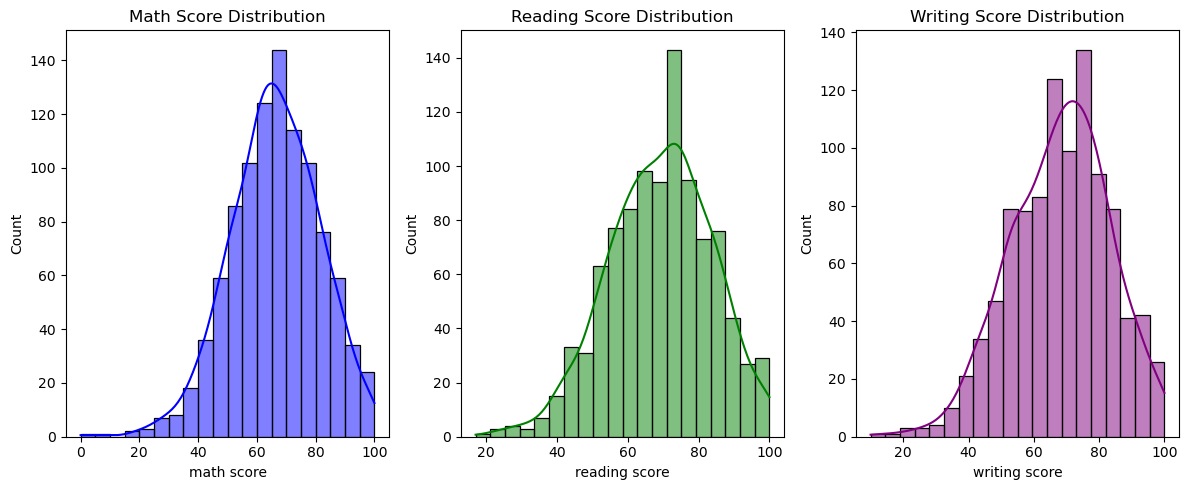

In [9]:
# Distribution of scores
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
sns.histplot(df["math score"], kde=True, bins=20, color='blue')
plt.title("Math Score Distribution")

plt.subplot(1,3,2)
sns.histplot(df["reading score"], kde=True, bins=20, color='green')
plt.title("Reading Score Distribution")

plt.subplot(1,3,3)
sns.histplot(df["writing score"], kde=True, bins=20, color='purple')
plt.title("Writing Score Distribution")

plt.tight_layout()
plt.show()

- They all look approximately normal (bell-shaped).
- Slight left skew means a few very low scores exist (students who struggled a lot).
- Most students score around 60–80 in all subjects.
- The left tail in all three plots shows a small group of very low performers.
- Math scores seem more spread out and include extreme lows (0).

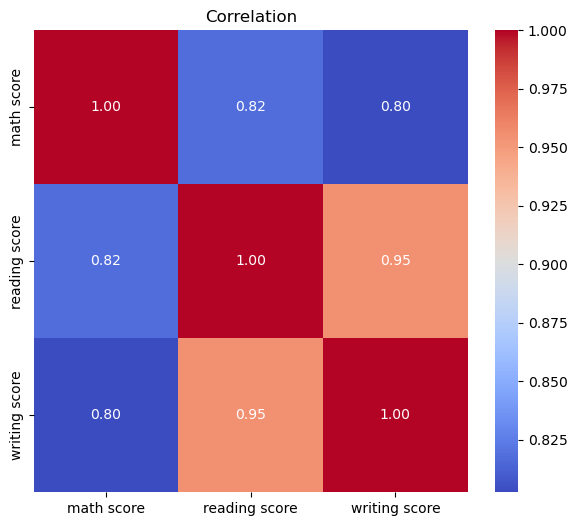

In [10]:
plt.figure(figsize=(7,6))
sns.heatmap(df[['math score','reading score','writing score']].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation")
plt.show()

- **Math vs Reading:** 0.82 → strong positive correlation
- **Math vs Writing:** 0.80 → strong positive correlation
- **Reading vs Writing:** 0.95 → very strong correlation (multicollinearity)

In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools import add_constant

# Select numerical features
X = add_constant(df[['math score', 'reading score', 'writing score']])

# Calculate VIF for each feature
vif = pd.DataFrame({
    "Feature": X.columns,
    "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})

print(vif)

         Feature        VIF
0          const  24.244531
1     math score   3.067307
2  reading score  12.296731
3  writing score  11.460202


- That is 100% Multicollinearity for Reading and Writing.

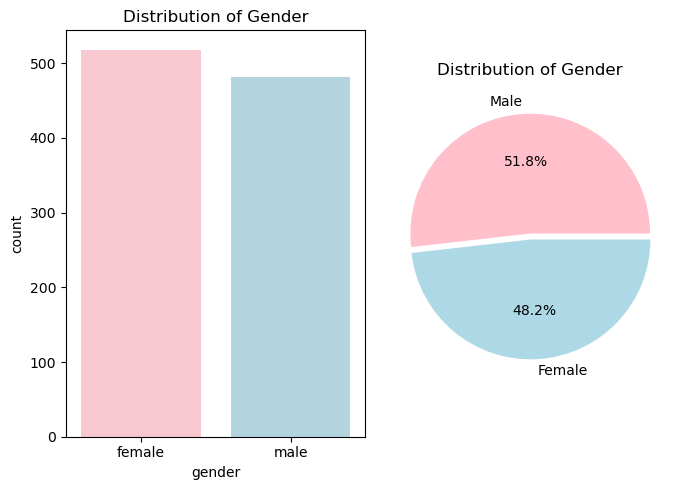

In [12]:
plt.figure(figsize=(7,5))
plt.subplot(1,2,1)
sns.countplot(data=df, x='gender', hue='gender', palette={"male": "lightblue", "female": "pink"})
plt.title("Distribution of Gender")

plt.subplot(1,2,2)
plt.pie(x=df['gender'].value_counts(), labels=['Male', 'Female'], explode=[0, 0.05],autopct='%1.1f%%', colors=['pink', 'lightblue'])
plt.title("Distribution of Gender")

plt.tight_layout()
plt.show()

- The Distribution between Gender is balanced by Female = 51.8% & Males = 48.2%.

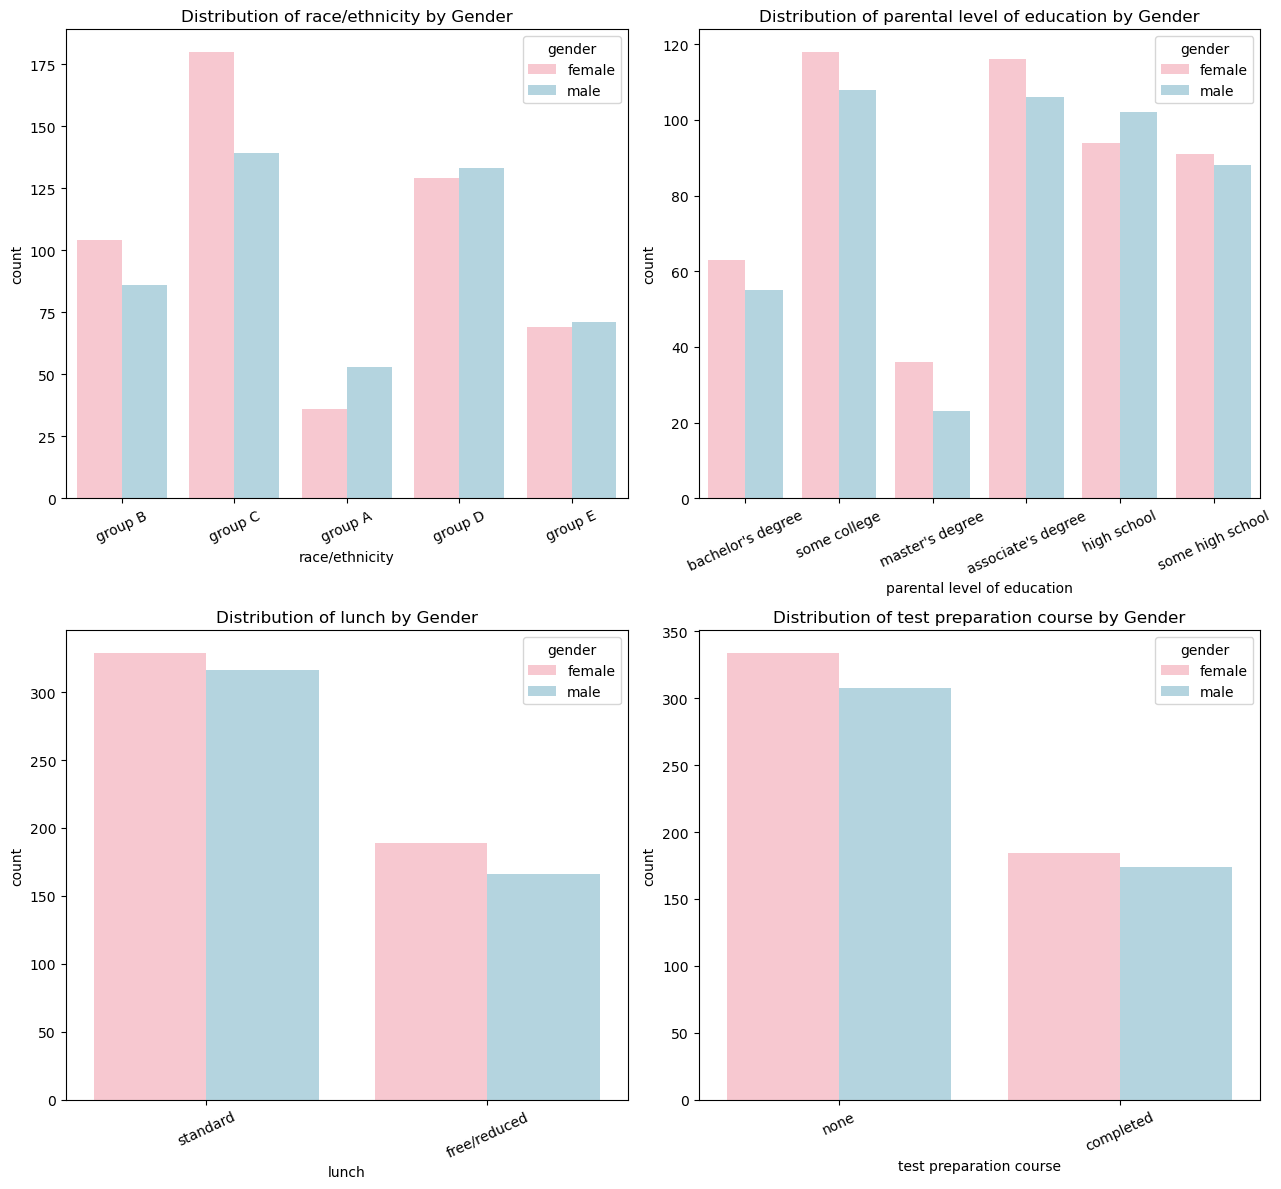

In [13]:
categorical_cols = ['race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']

plt.figure(figsize=(13,12))

for i, col in enumerate(categorical_cols, 1):
    plt.subplot(2, 2, i)  
    sns.countplot(data=df, x=col, hue="gender", palette={"male": "lightblue", "female": "pink"})
    plt.title(f"Distribution of {col} by Gender")
    plt.xticks(rotation=25)

plt.tight_layout()
plt.show()

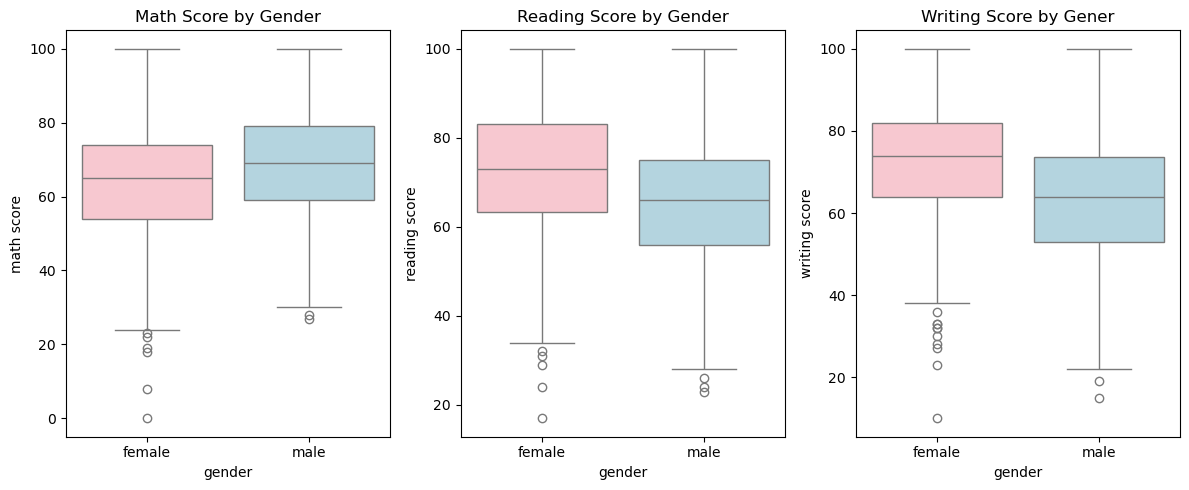

In [14]:
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
sns.boxplot(x="gender", y="math score", data=df, hue="gender", palette={"male": "lightblue", "female": "pink"})
plt.title("Math Score by Gender")

plt.subplot(1,3,2)
sns.boxplot(x="gender", y="reading score", data=df, hue="gender", palette={"male": "lightblue", "female": "pink"})
plt.title("Reading Score by Gender")

plt.subplot(1,3,3)
sns.boxplot(x="gender", y="writing score", data=df, hue="gender", palette={"male": "lightblue", "female": "pink"})
plt.title("Writing Score by Gener")

plt.tight_layout()
plt.show()

- **Males:** Slight advantage in math.
- **Females:** Stronger in reading & writing.
- **Outliers:** Mostly low performers, pulling distributions downward.

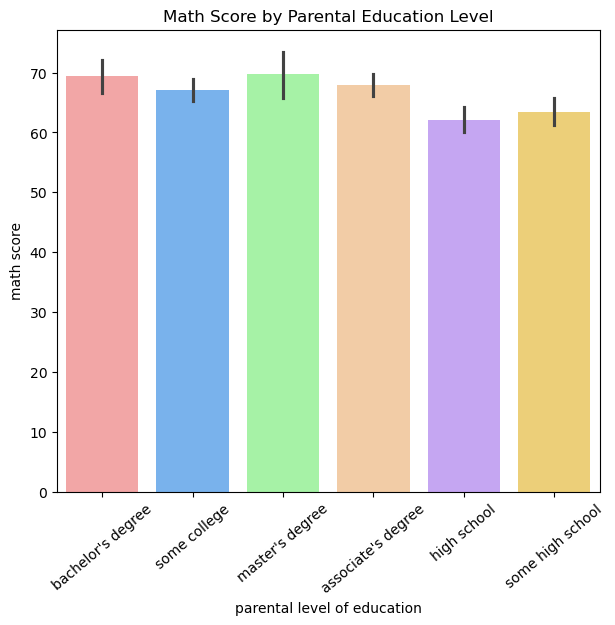

In [15]:
colors = ["#FF9999", "#66B2FF", "#99FF99", "#FFCC99", "#C299FF", "#FFD966"]
plt.figure(figsize=(7,6))
sns.barplot(data=df, x='parental level of education', y='math score', hue='parental level of education', palette=colors)
plt.title("Math Score by Parental Education Level")
plt.xticks(rotation=40)
plt.show()

- Students whose parents have a high education degree perorm well in math.

## Preprocessing

In [16]:
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [17]:
df['average score'] = df['math score'] + df['reading score'] + df['writing score']/3

In [18]:
df = df.drop(['reading score', 'writing score'], axis=1)

In [19]:
education_order = {
    'some high school': 1,
    'high school': 2,
    'some college': 3,
    'associate’s degree': 4,
    'bachelor’s degree': 5,
    'master’s degree': 6
}

df['parental level of education'] = df['parental level of education'].map(education_order)

# Fill any NaNs (in case of unseen values)
df['parental level of education'] = df['parental level of education'].fillna(0)

In [20]:
X = df.drop(columns=['average score'])
y = df['average score']

In [21]:
categorical_cols = ['gender', 'race/ethnicity', 'lunch', 'test preparation course']
numeric_cols = ['parental level of education']

In [22]:
categorical_transformer = OneHotEncoder(drop="first", sparse_output=False)
numeric_transformer = RobustScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_cols),
        ("num", numeric_transformer, numeric_cols)
    ],
    remainder="passthrough"
)

In [23]:
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor)
])

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
X_train_processed = pipeline.fit_transform(X_train)
X_test_processed = pipeline.transform(X_test)

print("Training features shape:", X_train_processed.shape)
print("Test features shape:", X_test_processed.shape)

Training features shape: (800, 9)
Test features shape: (200, 9)


## Modeling & Evaluation

### Linear Regression

In [26]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_processed, y_train)
y_pred_train = lin_reg.predict(X_train_processed)
y_pred_test = lin_reg.predict(X_test_processed)

print("--- Linear Regression ---")
print("R² Score (Test):", r2_score(y_test, y_pred_test))
print("RMSE (Test):", np.sqrt(mean_squared_error(y_test, y_pred_test)))

print("R² Score (Train):", r2_score(y_train, y_pred_train))
print("RMSE (Train):", np.sqrt(mean_squared_error(y_train, y_pred_train)))

--- Linear Regression ---
R² Score (Test): 0.9548466352093284
RMSE (Test): 7.2399160118099255
R² Score (Train): 0.9506802563350608
RMSE (Train): 7.2751165424941835


The Linear Regression model achieved an **R² score of ~0.95** on both training and test sets, with an **RMSE of ~7.2**.  
- The close values between train and test R² indicate that the model generalizes well and is **not overfitting**.  
- An R² of 0.95 means the model explains about **95% of the variance** in student academic performance, which is a strong result. 
- RMSE around 7 suggests that the average prediction error is about 7 points in the performance score.  
- Overall, Linear Regression provides a **strong baseline model**.

### Polynomial Regression

In [27]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_processed)
X_test_poly = poly.transform(X_test_processed)

lin_reg_poly = LinearRegression()
lin_reg_poly.fit(X_train_poly, y_train)

y_pred_train = lin_reg_poly.predict(X_train_poly)
y_pred_test = lin_reg_poly.predict(X_test_poly)

print("--- Polynomial Regression ---")
print("R² Score (Test):", r2_score(y_test, y_pred_test))
print("RMSE (Test):", np.sqrt(mean_squared_error(y_test, y_pred_test)))

print("R² Score (Train):", r2_score(y_train, y_pred_train))
print("RMSE (Train):", np.sqrt(mean_squared_error(y_train, y_pred_train)))

--- Polynomial Regression ---
R² Score (Test): 0.9532812337572105
RMSE (Test): 7.3643454300041284
R² Score (Train): 0.952013744603309
RMSE (Train): 7.176091704925236


The Polynomial Regression (degree=2) model performed very similarly to Linear Regression, with an **R² of ~0.95** and **RMSE ~7.2–7.3**.  
- The improvement over Linear Regression is negligible.  
- This suggests that the relationship between features and target is mostly **linear**, and higher-order interactions do not add much predictive power.  
- Polynomial features did not significantly improve performance and may only increase complexity.

### Random Forest

In [28]:
rf_reg = RandomForestRegressor(n_estimators=200, random_state=42)
rf_reg.fit(X_train_processed, y_train)
y_pred_test = rf_reg.predict(X_test_processed)
y_pred_train = rf_reg.predict(X_train_processed)

print("--- Random Forest Regressor ---")
print("R² Score (Test):", r2_score(y_test, y_pred_test))
print("RMSE (Test):", np.sqrt(mean_squared_error(y_test, y_pred_test)))

print("R² Score (Train):", r2_score(y_train, y_pred_train))
print("RMSE (Train):", np.sqrt(mean_squared_error(y_train, y_pred_train)))

--- Random Forest Regressor ---
R² Score (Test): 0.9366328100167323
RMSE (Test): 8.576709351963263
R² Score (Train): 0.9880999578718583
RMSE (Train): 3.57358238633152


The Random Forest model achieved an **R² of ~0.94** on the test set, with an **RMSE of ~8.6**.  
- On the training set, R² was extremely high (~0.99), indicating the model **fits the training data very well**.  
- However, the noticeable gap between train and test R² suggests **overfitting**: the model captures noise in the training data and loses generalization power.  
- While Random Forest can capture non-linear patterns, in this case it **overfits**, leading to slightly weaker test performance compared to Linear Regression.

### XGBoost

In [29]:
xgb_reg = XGBRegressor(n_estimators=300, learning_rate=0.05, random_state=42)
xgb_reg.fit(X_train_processed, y_train)
y_pred_test = xgb_reg.predict(X_test_processed)
y_pred_train = xgb_reg.predict(X_train_processed)

print("--- XGBoost Regressor ---")
print("R² Score (Test):", r2_score(y_test, y_pred_test))
print("RMSE (Test):", np.sqrt(mean_squared_error(y_test, y_pred_test)))

print("R² Score (Train):", r2_score(y_train, y_pred_train))
print("RMSE (Train):", np.sqrt(mean_squared_error(y_train, y_pred_train)))

--- XGBoost Regressor ---
R² Score (Test): 0.9348493769649739
RMSE (Test): 8.696565156966987
R² Score (Train): 0.984461255740442
RMSE (Train): 4.083546534195653


The XGBoost model achieved an **R² of ~0.93** on the test set and **RMSE ~8.7**, with a very high training R² (~0.98).  
- Like Random Forest, XGBoost shows **overfitting**, with much better training performance than test performance.  
- Test accuracy is slightly worse than Linear Regression.  
- XGBoost is powerful, but in this dataset, the simpler **Linear Regression outperforms it in generalization**.

In [30]:
# ---------------- Linear Regression ----------------
lin_reg = LinearRegression()
lin_reg.fit(X_train_processed, y_train)
y_pred_train_lin = lin_reg.predict(X_train_processed)
y_pred_test_lin = lin_reg.predict(X_test_processed)

# ---------------- Polynomial Regression ----------------
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_processed)
X_test_poly = poly.transform(X_test_processed)

lin_reg = LinearRegression()
lin_reg.fit(X_train_poly, y_train)
y_pred_train_poly = lin_reg.predict(X_train_poly)
y_pred_test_poly = lin_reg.predict(X_test_poly)

# ---------------- Random Forest ----------------
rf_reg = RandomForestRegressor(n_estimators=200, random_state=42)
rf_reg.fit(X_train_processed, y_train)
y_pred_train_rf = rf_reg.predict(X_train_processed)
y_pred_test_rf = rf_reg.predict(X_test_processed)

# ---------------- XGBoost ----------------
xgb_reg = XGBRegressor(n_estimators=300, learning_rate=0.1, random_state=42)
xgb_reg.fit(X_train_processed, y_train)
y_pred_train_xgb = xgb_reg.predict(X_train_processed)
y_pred_test_xgb = xgb_reg.predict(X_test_processed)

In [31]:
results = {
    "Linear Regression": {
        "R² Train": r2_score(y_train, y_pred_train_lin),
        "R² Test": r2_score(y_test, y_pred_test_lin),
        "RMSE Train": np.sqrt(mean_squared_error(y_train, y_pred_train_lin)),
        "RMSE Test": np.sqrt(mean_squared_error(y_test, y_pred_test_lin))
    },
    "Polynomial Regression": {
        "R² Train": r2_score(y_train, y_pred_train_poly),
        "R² Test": r2_score(y_test, y_pred_test_poly),
        "RMSE Train": np.sqrt(mean_squared_error(y_train, y_pred_train_poly)),
        "RMSE Test": np.sqrt(mean_squared_error(y_test, y_pred_test_poly))
    },
    "Random Forest": {
        "R² Train": r2_score(y_train, y_pred_train_rf),
        "R² Test": r2_score(y_test, y_pred_test_rf),
        "RMSE Train": np.sqrt(mean_squared_error(y_train, y_pred_train_rf)),
        "RMSE Test": np.sqrt(mean_squared_error(y_test, y_pred_test_rf))
    },
    "XGBoost": {
        "R² Train": r2_score(y_train, y_pred_train_xgb),
        "R² Test": r2_score(y_test, y_pred_test_xgb),
        "RMSE Train": np.sqrt(mean_squared_error(y_train, y_pred_train_xgb)),
        "RMSE Test": np.sqrt(mean_squared_error(y_test, y_pred_test_xgb))
    }
}

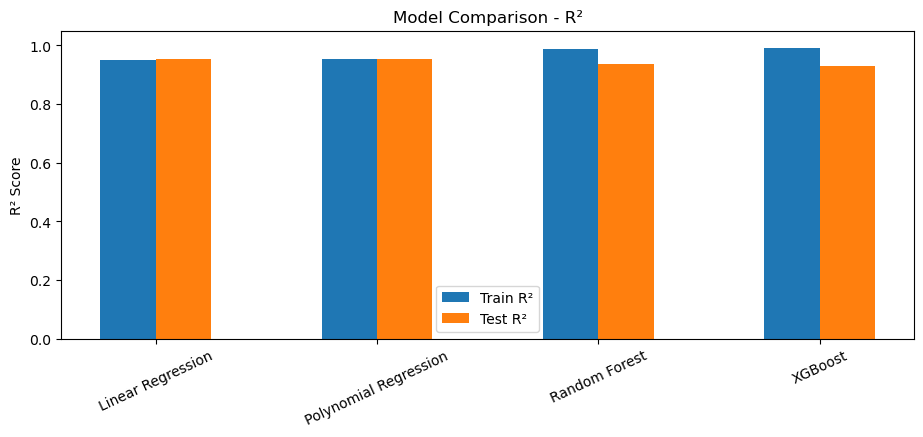

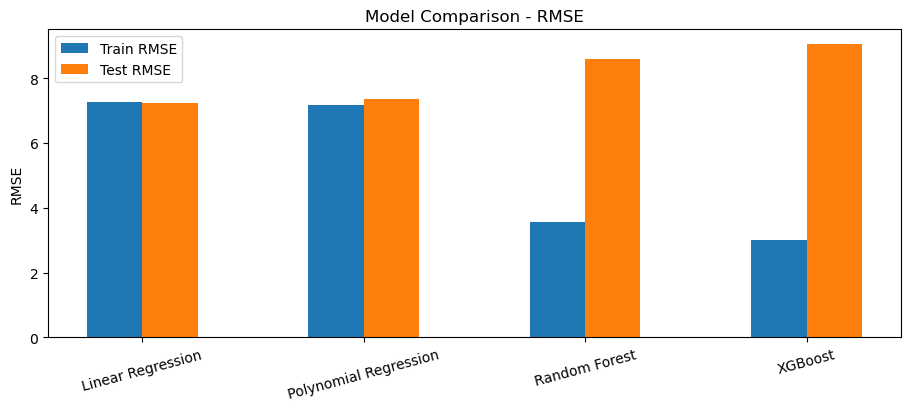

In [32]:
models = list(results.keys())
r2_train = [results[m]["R² Train"] for m in models]
r2_test = [results[m]["R² Test"] for m in models]
rmse_train = [results[m]["RMSE Train"] for m in models]
rmse_test = [results[m]["RMSE Test"] for m in models]

x = np.arange(len(models))
width = 0.25

# Plot R²
plt.figure(figsize=(11,4))
plt.bar(x - width/2, r2_train, width, label="Train R²")
plt.bar(x + width/2, r2_test, width, label="Test R²")
plt.xticks(x, models, rotation=25)
plt.ylabel("R² Score")
plt.title("Model Comparison - R²")
plt.legend()
plt.ylim(0, 1.05)
plt.show()

# Plot RMSE
plt.figure(figsize=(11,4))
plt.bar(x - width/2, rmse_train, width, label="Train RMSE")
plt.bar(x + width/2, rmse_test, width, label="Test RMSE")
plt.xticks(x, models, rotation=15)
plt.ylabel("RMSE")
plt.title("Model Comparison - RMSE")
plt.legend()
plt.show()

### Hypertuning

In [33]:
# Random Forest Tuning
rf_reg = RandomForestRegressor(random_state=42)

rf_param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_random = RandomizedSearchCV(
    estimator=rf_reg,
    param_distributions=rf_param_dist,
    n_iter=20,
    cv=5,
    scoring='r2',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

rf_random.fit(X_train_processed, y_train)

print("Best RF Params:", rf_random.best_params_)
print("Best RF CV Score:", rf_random.best_score_)

rf_reg = rf_random.best_estimator_  # overwrite with tuned model
y_pred_train = rf_reg.predict(X_train_processed)
y_pred_test = rf_reg.predict(X_test_processed)

print("--- Random Forest (Tuned) ---")
print("R² Score (Test):", r2_score(y_test, y_pred_test))
print("RMSE (Test):", np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("R² Score (Train):", r2_score(y_train, y_pred_train))
print("RMSE (Train):", np.sqrt(mean_squared_error(y_train, y_pred_train)))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best RF Params: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 10}
Best RF CV Score: 0.9356314390140588
--- Random Forest (Tuned) ---
R² Score (Test): 0.9384740251226161
RMSE (Test): 8.451187174640005
R² Score (Train): 0.966194148122867
RMSE (Train): 6.023175139264562


- **Tuned XGBoost** improved test performance to **R² ~0.95** and RMSE ~7.8, while maintaining a reasonable training score.  
  - This reduces overfitting and brings XGBoost closer to Linear Regression performance.    

In [34]:
# XGBoost Tuning
xgb_reg = XGBRegressor(random_state=42, n_jobs=-1)

xgb_param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_random = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=xgb_param_dist,
    n_iter=20,
    cv=5,
    scoring='r2',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

xgb_random.fit(X_train_processed, y_train)

print("Best XGB Params:", xgb_random.best_params_)
print("Best XGB CV Score:", xgb_random.best_score_)

xgb_reg = xgb_random.best_estimator_  # overwrite with tuned model
y_pred_train = xgb_reg.predict(X_train_processed)
y_pred_test = xgb_reg.predict(X_test_processed)

print("--- XGBoost (Tuned) ---")
print("R² Score (Test):", r2_score(y_test, y_pred_test))
print("RMSE (Test):", np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("R² Score (Train):", r2_score(y_train, y_pred_train))
print("RMSE (Train):", np.sqrt(mean_squared_error(y_train, y_pred_train)))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best XGB Params: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.6}
Best XGB CV Score: 0.9415526039018045
--- XGBoost (Tuned) ---
R² Score (Test): 0.9472149306253124
RMSE (Test): 7.8278774315749455
R² Score (Train): 0.9578606619693482
RMSE (Train): 6.724707578474577


- **Tuned Random Forest** achieved **R² ~0.94** and RMSE ~8.4 on test data, still showing signs of overfitting, but slightly better balanced than before.
- Tuning helped both models, especially XGBoost, which is now competitive with Linear Regression.  
However, Linear Regression remains **the most stable and interpretable model** with consistently strong results.

## Conclusion

In [35]:
# ---- Linear Regression ----
lin_reg_base = LinearRegression()
lin_reg_base.fit(X_train_processed, y_train)
y_pred_train_lin = lin_reg_base.predict(X_train_processed)
y_pred_test_lin = lin_reg_base.predict(X_test_processed)

# ---- Polynomial Regression ----
y_pred_train_poly = lin_reg_poly.predict(X_train_poly)
y_pred_test_poly = lin_reg_poly.predict(X_test_poly)

# ---- Random Forest (Tuned) ----
y_pred_train_rf = rf_reg.predict(X_train_processed)
y_pred_test_rf = rf_reg.predict(X_test_processed)

# ---- XGBoost (Tuned) ----
y_pred_train_xgb = xgb_reg.predict(X_train_processed)
y_pred_test_xgb = xgb_reg.predict(X_test_processed)

# ---- Results dictionary ----
results = {
    "Model": ["Linear Regression", "Polynomial Regression", "Random Forest (Tuned)", "XGBoost (Tuned)"],
    "R² (Train)": [
        r2_score(y_train, y_pred_train_lin),
        r2_score(y_train, y_pred_train_poly),
        r2_score(y_train, y_pred_train_rf),
        r2_score(y_train, y_pred_train_xgb)
    ],
    "R² (Test)": [
        r2_score(y_test, y_pred_test_lin),
        r2_score(y_test, y_pred_test_poly),
        r2_score(y_test, y_pred_test_rf),
        r2_score(y_test, y_pred_test_xgb)
    ],
    "RMSE (Train)": [
        np.sqrt(mean_squared_error(y_train, y_pred_train_lin)),
        np.sqrt(mean_squared_error(y_train, y_pred_train_poly)),
        np.sqrt(mean_squared_error(y_train, y_pred_train_rf)),
        np.sqrt(mean_squared_error(y_train, y_pred_train_xgb))
    ],
    "RMSE (Test)": [
        np.sqrt(mean_squared_error(y_test, y_pred_test_lin)),
        np.sqrt(mean_squared_error(y_test, y_pred_test_poly)),
        np.sqrt(mean_squared_error(y_test, y_pred_test_rf)),
        np.sqrt(mean_squared_error(y_test, y_pred_test_xgb))
    ]
}

# ---- Create DataFrame ----
df_results = pd.DataFrame(results)

# Find best model (highest Test R²)
best_idx = df_results["R² (Test)"].idxmax()

# Highlight best row
def highlight_best(s):
    return ['background-color: lightgreen' if i == best_idx else '' for i in range(len(s))]

df_results_styled = df_results.style.apply(highlight_best, axis=0)
df_results_styled

,Model,R² (Train),R² (Test),RMSE (Train),RMSE (Test)
0,Linear Regression,0.950680,0.954847,7.275117,7.239916
1,Polynomial Regression,0.952014,0.953281,7.176092,7.364345
2,Random Forest (Tuned),0.966194,0.938474,6.023175,8.451187
3,XGBoost (Tuned),0.957861,0.947215,6.724708,7.827877


- **Linear Regression**: Strong baseline, R² ~0.95, balanced train/test performance, stable and interpretable.  
- **Polynomial Regression**: No significant improvement, adds unnecessary complexity.  
- **Random Forest**: Overfits the data, weaker test performance.  
- **XGBoost**: Initially overfit, but tuning improved generalization close to Linear Regression.  

- **Best Model**: Linear Regression remains the most reliable and interpretable model, while tuned XGBoost is a strong alternative if slightly more complexity is acceptable.  
- For practical purposes, Linear Regression is recommended due to its **simplicity, interpretability, and competitive accuracy**.
